In [10]:
# ===================== Cell 1: 导入库 & 载入数据 & 预处理 =====================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from numpy.random import seed
from sklearn.datasets import load_iris

# 1. 使用 sklearn 自带的 Iris 数据集（不需要上网）
iris = load_iris()

# 构造一个和原来类似的 DataFrame（主要是方便查看，不是必须）
df = pd.DataFrame(
    iris.data,
    columns=['Sepal length', 'Sepal width',
             'Petal length', 'Petal width']
)
df['Class label'] = [iris.target_names[i] for i in iris.target]

# 2. 特征：只取花瓣长、花瓣宽（第 3、4 列）
X_all = iris.data[:, [2, 3]]   # Petal length, Petal width

# 标签：0,1,2 三类
y_all = iris.target

# 3. 按照课程 / lab 的做法，只保留后两类（索引 50~149），做二分类
# 数据顺序：0~49=setosa(0)，50~99=versicolor(1)，100~149=virginica(2)
X = X_all[50:150]
y = y_all[50:150]

# 把其中一类改成 -1（另一类保持 1），变成 {-1, 1} 二分类
# 这里把 virginica(2) 映射为 -1，versicolor(1) 映射为 1
y = np.where(y == 2, -1, 1)

# 4. 划分训练 / 测试集（test_size = 20%）
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=1
)

# 5. 标准化，只用训练集来 fit
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('# Training data points:', X_train.shape[0])
print('# Testing  data points:', X_test.shape[0])
print('Class labels after selection & mapping:', np.unique(y))


# Training data points: 80
# Testing  data points: 20
Class labels after selection & mapping: [-1  1]


In [12]:
# ===================== Cell 2: 带 mini-batch 的 Adaline 实现 =====================

class AdalineMiniBatch(object):
    """ADAptive LInear NEuron classifier with mini-batch SGD.

    Parameters
    ----------
    eta : float
        Learning rate (0.0 ~ 1.0).
    n_iter : int
        Number of epochs (passes over the training dataset).
    batch_size : int
        M, mini-batch size. M=1 时就是普通的 SGD。
    shuffle : bool
        Whether to shuffle training data every epoch.
    random_state : int
        Seed for random number generator.

    Attributes
    ----------
    w_ : 1d-array
        Weights after fitting.
    cost_ : list
        Average cost (per batch) in each epoch.
    """

    def __init__(self, eta=0.01, n_iter=20,
                 batch_size=1, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_state = random_state
        if random_state is not None:
            seed(random_state)

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
        y : array-like, shape = [n_samples]

        Returns
        -------
        self : object
        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []

        n_samples = X.shape[0]
        # 只用前 n_batches * batch_size 个样本，多余的忽略
        n_batches = n_samples // self.batch_size

        for _ in range(self.n_iter):
            X_epoch = X.copy()
            y_epoch = y.copy()

            if self.shuffle:
                X_epoch, y_epoch = self._shuffle(X_epoch, y_epoch)

            epoch_cost = 0.0

            for b in range(n_batches):
                start = b * self.batch_size
                end = start + self.batch_size

                X_batch = X_epoch[start:end]
                y_batch = y_epoch[start:end]

                # 线性输出
                output = self.activation(X_batch)
                errors = y_batch - output

                # 批次 cost（SSE/2）
                batch_cost = (errors ** 2).sum() / (2.0 * self.batch_size)
                epoch_cost += batch_cost

                # mini-batch 梯度更新（与批量 GD 类似，但只用这个 batch）
                self.w_[1:] += self.eta * X_batch.T.dot(errors)
                self.w_[0] += self.eta * errors.sum()

            # 记录每个 epoch 的平均 cost（对 batch 取平均）
            self.cost_.append(epoch_cost / n_batches)

        return self

    def _shuffle(self, X, y):
        """Shuffle training data."""
        r = np.random.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """Randomly initialize weights."""
        # m = 特征数
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)

    def net_input(self, X):
        """Compute net input."""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation."""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step."""
        return np.where(self.activation(X) >= 0.0, 1, -1)


=== Training Adaline with batch_size M=1 ===
Accuracy (M=1): 0.85

=== Training Adaline with batch_size M=5 ===
Accuracy (M=5): 0.85

=== Training Adaline with batch_size M=20 ===
Accuracy (M=20): 0.85



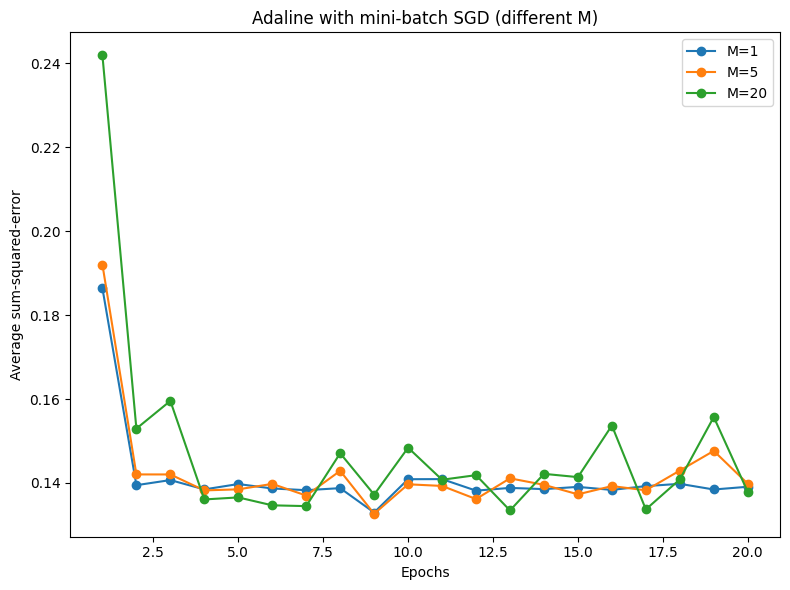

In [21]:
# 固定的学习率和训练轮数
eta = 0.03
n_epochs = 20

# 三个不同的 M（包含 M=1 的普通 SGD）
batch_sizes = [1, 5, 20]

models = []
for M in batch_sizes:
    print(f'=== Training Adaline with batch_size M={M} ===')
    ada_mb = AdalineMiniBatch(
        eta=eta,
        n_iter=n_epochs,
        batch_size=M,
        shuffle=True,
        random_state=1
    )
    ada_mb.fit(X_train_std, y_train)

    # 测试集准确率
    y_pred = ada_mb.predict(X_test_std)
    acc = accuracy_score(y_test, y_pred)
    print(f'Accuracy (M={M}): {acc:.2f}\n')

    models.append(ada_mb)

# 画 cost vs epochs 曲线
plt.figure(figsize=(8, 6))
epochs = np.arange(1, n_epochs + 1)

for M, model in zip(batch_sizes, models):
    plt.plot(epochs, model.cost_, marker='o', label=f'M={M}')

plt.xlabel('Epochs')
plt.ylabel('Average sum-squared-error')
plt.title('Adaline with mini-batch SGD (different M)')
plt.legend(loc='upper right')
plt.tight_layout()


plt.savefig('Lab04-1_student_id.png', dpi=300)
plt.show()
